In [1]:
import tensorflow as tf
from edward.models import Normal
from flows import floatX
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(2)])
#     ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
out_flow = DFlow([LinearChol(n*dim[0]*dim[1], name='approx')])

In [8]:
outputs = tf.reshape(out_flow.output, [1, n, dim[0]*dim[1]])

In [9]:
prior = PWalk.logdens(outputs)

In [10]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [11]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [12]:
logl = create_loglik2()

In [13]:
ent = out_flow.logdens

In [14]:
ent

<tf.Tensor 'sub_1:0' shape=() dtype=float64>

In [15]:
df = dim[0]*dim[1]*5
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [16]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [17]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [18]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [19]:
sess = tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

In [21]:
prior.eval(), ent.eval(), logl.eval()

(-2658496.6709917434, -346.6856836290738, -2772.4231692980948)

In [22]:
loss.eval()

12652.879483862796

In [23]:
np.set_printoptions(precision=4)

In [24]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 1.0000e+04,  1.0931e+00, -5.3984e+00],
       [ 1.0931e+00,  1.0000e+04,  2.3170e+00],
       [-5.3984e+00,  2.3170e+00,  1.0000e+04]])

In [25]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [ ]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

0.35695852679966056
[[16.5777  0.1642 -0.3625]
 [ 0.1642 17.0887 -1.2224]
 [-0.3625 -1.2224 13.8068]]


0.3726198549039658
[[16.593   0.1628 -0.3549]
 [ 0.1628 17.23   -1.2254]
 [-0.3549 -1.2254 13.7547]]


0.3496976487527238
[[16.5772  0.1633 -0.3609]
 [ 0.1633 17.0999 -1.2021]
 [-0.3609 -1.2021 13.7742]]


0.36906880224775507
[[16.5755  0.1547 -0.3436]
 [ 0.1547 17.1341 -1.1981]
 [-0.3436 -1.1981 13.7721]]


0.35962389605056605
[[16.5808  0.152  -0.3454]
 [ 0.152  17.1184 -1.2086]
 [-0.3454 -1.2086 13.7587]]


0.37318641447099615
[[16.2039  0.187  -0.336 ]
 [ 0.187  16.9968 -1.1768]
 [-0.336  -1.1768 13.5139]]


0.35227114978089585
[[16.1754  0.1955 -0.3249]
 [ 0.1955 16.9826 -1.1883]
 [-0.3249 -1.1883 13.5157]]


0.35231081493118105
[[16.2321  0.1976 -0.3343]
 [ 0.1976 17.0409 -1.184 ]
 [-0.3343 -1.184  13.5777]]


0.32784073038980216
[[16.2407  0.1849 -0.3414]
 [ 0.1849 16.9384 -1.1865]
 [-0.3414 -1.1865 13.5408]]


0.3593432056844955
[[16.328   0.1866 -0.3471]
 [ 0.1866 17.0349 -1

0.3450516133440123
[[16.1349  0.1384 -0.3621]
 [ 0.1384 16.8495 -1.1726]
 [-0.3621 -1.1726 13.3715]]


0.37539255067046373
[[16.2089  0.1377 -0.362 ]
 [ 0.1377 16.836  -1.1722]
 [-0.362  -1.1722 13.3952]]


0.38041748538261905
[[16.2428  0.1313 -0.3655]
 [ 0.1313 16.7416 -1.1597]
 [-0.3655 -1.1597 13.4337]]


0.380391206435923
[[16.1581  0.1373 -0.3599]
 [ 0.1373 16.7609 -1.1556]
 [-0.3599 -1.1556 13.4339]]


0.3497595103814913
[[16.1222  0.1358 -0.3566]
 [ 0.1358 16.821  -1.1606]
 [-0.3566 -1.1606 13.4332]]


0.37418409492193505
[[16.2806  0.1489 -0.3483]
 [ 0.1489 16.8326 -1.1649]
 [-0.3483 -1.1649 13.4924]]


0.35352163477018617
[[16.2521  0.1394 -0.3541]
 [ 0.1394 16.8346 -1.1548]
 [-0.3541 -1.1548 13.4552]]


0.37411480910383604
[[16.2442  0.1428 -0.3558]
 [ 0.1428 16.7957 -1.146 ]
 [-0.3558 -1.146  13.5243]]


0.35730081021946974
[[16.1717  0.155  -0.3452]
 [ 0.155  16.7199 -1.1513]
 [-0.3452 -1.1513 13.4909]]


0.34101149639285744
[[16.094   0.165  -0.3451]
 [ 0.165  16.6989 -1.

0.35053675531957496
[[15.994   0.1892 -0.3306]
 [ 0.1892 16.509  -1.1834]
 [-0.3306 -1.1834 13.3259]]


0.33059949402060007
[[15.9897  0.196  -0.3286]
 [ 0.196  16.619  -1.177 ]
 [-0.3286 -1.177  13.3354]]


0.3696755214638151
[[15.9805  0.185  -0.335 ]
 [ 0.185  16.7178 -1.1825]
 [-0.335  -1.1825 13.3391]]


0.36991571660953054
[[16.0465  0.1899 -0.3368]
 [ 0.1899 16.5977 -1.1906]
 [-0.3368 -1.1906 13.3595]]


0.35102171414947636
[[16.0445  0.1878 -0.3237]
 [ 0.1878 16.614  -1.1886]
 [-0.3237 -1.1886 13.3253]]


0.38182497417514366
[[15.9691  0.1907 -0.3099]
 [ 0.1907 16.5212 -1.1896]
 [-0.3099 -1.1896 13.3625]]


0.3501230581139931
[[16.085   0.1911 -0.3259]
 [ 0.1911 16.5184 -1.1878]
 [-0.3259 -1.1878 13.2451]]


0.37491131647311277
[[16.1653  0.1878 -0.3418]
 [ 0.1878 16.5387 -1.1982]
 [-0.3418 -1.1982 13.2898]]


0.37678218645675143
[[16.1526  0.1931 -0.3421]
 [ 0.1931 16.6576 -1.2153]
 [-0.3421 -1.2153 13.228 ]]


0.3715775635356407
[[16.1069  0.199  -0.345 ]
 [ 0.199  16.647  -1

0.4288909278708392
[[16.0596  0.1664 -0.2994]
 [ 0.1664 16.4938 -1.1458]
 [-0.2994 -1.1458 13.1434]]


0.33704152299149814
[[16.0709  0.161  -0.2993]
 [ 0.161  16.5278 -1.138 ]
 [-0.2993 -1.138  13.0899]]


0.3349984992008499
[[16.0278  0.1698 -0.3033]
 [ 0.1698 16.5767 -1.1401]
 [-0.3033 -1.1401 13.137 ]]


0.35928093005941886
[[15.9842  0.1736 -0.2901]
 [ 0.1736 16.6231 -1.149 ]
 [-0.2901 -1.149  13.1769]]


0.32805515486672826
[[16.0708  0.1778 -0.2905]
 [ 0.1778 16.6285 -1.1483]
 [-0.2905 -1.1483 13.1672]]


0.36639564675842257
[[16.0026  0.1791 -0.2814]
 [ 0.1791 16.4786 -1.1415]
 [-0.2814 -1.1415 13.1842]]


0.3747177974270807
[[16.0128  0.1771 -0.2928]
 [ 0.1771 16.4448 -1.1424]
 [-0.2928 -1.1424 13.2066]]


0.3797995220923378
[[16.0082  0.1692 -0.2989]
 [ 0.1692 16.4669 -1.1378]
 [-0.2989 -1.1378 13.2962]]


0.37064854569381217
[[16.0528  0.1673 -0.2988]
 [ 0.1673 16.5716 -1.1282]
 [-0.2988 -1.1282 13.2583]]


0.3871123195205926
[[16.0783  0.1685 -0.2987]
 [ 0.1685 16.5627 -1.1

0.3849583062283121
[[16.0221  0.1444 -0.3334]
 [ 0.1444 16.4403 -1.155 ]
 [-0.3334 -1.155  13.0554]]


0.35652659147135074
[[15.9838  0.1455 -0.3321]
 [ 0.1455 16.4312 -1.1582]
 [-0.3321 -1.1582 13.0878]]


0.38928025170399805
[[15.9337  0.1447 -0.3366]
 [ 0.1447 16.467  -1.1686]
 [-0.3366 -1.1686 13.0535]]


0.35831953143639894
[[15.8513  0.1503 -0.344 ]
 [ 0.1503 16.472  -1.1751]
 [-0.344  -1.1751 13.1189]]


0.37488929138946075
[[15.8857  0.1511 -0.3447]
 [ 0.1511 16.4526 -1.1832]
 [-0.3447 -1.1832 13.0885]]


0.34871212375239524
[[15.8206  0.1511 -0.3476]
 [ 0.1511 16.4214 -1.1761]
 [-0.3476 -1.1761 13.1131]]


0.3348440834693346
[[15.7268  0.1454 -0.3416]
 [ 0.1454 16.3665 -1.1825]
 [-0.3416 -1.1825 13.183 ]]


0.3391038338880025
[[15.7138  0.1483 -0.3318]
 [ 0.1483 16.3738 -1.1674]
 [-0.3318 -1.1674 13.1169]]


0.35208370925714655
[[15.6854  0.1476 -0.3225]
 [ 0.1476 16.3847 -1.165 ]
 [-0.3225 -1.165  13.0352]]


0.35950398960619767
[[15.6591  0.1566 -0.3255]
 [ 0.1566 16.4309 -1

0.39965579406005153
[[15.7655  0.1384 -0.2896]
 [ 0.1384 16.2636 -1.1383]
 [-0.2896 -1.1383 13.0202]]


0.3537477308546684
[[15.7368  0.137  -0.305 ]
 [ 0.137  16.1509 -1.1287]
 [-0.305  -1.1287 13.0051]]


0.37837196382436716
[[15.7643  0.1241 -0.3061]
 [ 0.1241 16.1249 -1.1264]
 [-0.3061 -1.1264 12.952 ]]


0.3573940783598292
[[15.7698  0.115  -0.3072]
 [ 0.115  16.2003 -1.1265]
 [-0.3072 -1.1265 13.0568]]


0.3692703077924747
[[15.7822  0.119  -0.3034]
 [ 0.119  16.1132 -1.1268]
 [-0.3034 -1.1268 12.9948]]


0.36423260837850485
[[15.7984  0.116  -0.3061]
 [ 0.116  16.0666 -1.1319]
 [-0.3061 -1.1319 13.0399]]


0.34132666976292053
[[15.7634  0.1166 -0.3138]
 [ 0.1166 16.0684 -1.1357]
 [-0.3138 -1.1357 13.0003]]


0.3652935384755345
[[15.7872  0.1162 -0.3196]
 [ 0.1162 16.0887 -1.1401]
 [-0.3196 -1.1401 12.9664]]


0.33605915129185904
[[15.8087  0.1163 -0.3263]
 [ 0.1163 16.0911 -1.1383]
 [-0.3263 -1.1383 12.9942]]


0.3418014764517488
[[15.7844  0.1086 -0.3383]
 [ 0.1086 16.0828 -1.1

0.35061296979619033
[[15.6571  0.1671 -0.3098]
 [ 0.1671 16.179  -1.1279]
 [-0.3098 -1.1279 12.925 ]]


0.380117291186178
[[15.5433  0.1577 -0.3151]
 [ 0.1577 16.1342 -1.1216]
 [-0.3151 -1.1216 12.8714]]


0.36174704795793927
[[15.5842  0.1471 -0.3181]
 [ 0.1471 16.0759 -1.1191]
 [-0.3181 -1.1191 12.8596]]


0.37615732972658833
[[15.6293  0.1501 -0.3083]
 [ 0.1501 16.1297 -1.1348]
 [-0.3083 -1.1348 12.8524]]


0.34661886589116087
[[15.6929  0.1551 -0.324 ]
 [ 0.1551 16.0559 -1.1327]
 [-0.324  -1.1327 12.9109]]


0.3557834561100973
[[15.8042  0.1624 -0.3152]
 [ 0.1624 16.0499 -1.1381]
 [-0.3152 -1.1381 12.8473]]


0.34657256646675655
[[15.673   0.1774 -0.3262]
 [ 0.1774 16.023  -1.1372]
 [-0.3262 -1.1372 12.8087]]


0.3366198199596605
[[15.6268  0.1695 -0.3356]
 [ 0.1695 16.1462 -1.1461]
 [-0.3356 -1.1461 12.85  ]]


0.3356462228309077
[[15.7084  0.1665 -0.3345]
 [ 0.1665 16.1796 -1.1521]
 [-0.3345 -1.1521 12.8801]]


0.37575202140101904
[[15.727   0.1569 -0.3236]
 [ 0.1569 16.1603 -1.1

0.32274441516011837
[[15.4936  0.156  -0.276 ]
 [ 0.156  16.067  -1.1594]
 [-0.276  -1.1594 12.8439]]


0.37979674283174497
[[15.4484  0.1454 -0.2813]
 [ 0.1454 16.1033 -1.1467]
 [-0.2813 -1.1467 12.8036]]


0.346699517311758
[[15.4662  0.1489 -0.2958]
 [ 0.1489 16.0972 -1.1426]
 [-0.2958 -1.1426 12.8154]]


0.3423921349717342
[[15.4708  0.142  -0.2937]
 [ 0.142  16.1167 -1.1255]
 [-0.2937 -1.1255 12.801 ]]


0.3866111506334004
[[15.5029  0.1501 -0.2867]
 [ 0.1501 16.071  -1.1258]
 [-0.2867 -1.1258 12.7815]]


0.3778086408735814
[[15.4312  0.1517 -0.2915]
 [ 0.1517 16.057  -1.1309]
 [-0.2915 -1.1309 12.8256]]


0.34706018890918694
[[15.4788  0.1502 -0.2949]
 [ 0.1502 15.9467 -1.1246]
 [-0.2949 -1.1246 12.7901]]


0.3767381001779443
[[15.5366  0.1543 -0.302 ]
 [ 0.1543 15.8173 -1.1075]
 [-0.302  -1.1075 12.7563]]


0.3718053192107559
[[15.5908  0.1527 -0.3024]
 [ 0.1527 15.7505 -1.1077]
 [-0.3024 -1.1077 12.7327]]


0.36908052694024795
[[15.6184  0.1405 -0.311 ]
 [ 0.1405 15.7988 -1.117

0.35502140018693484
[[15.4154  0.1665 -0.2975]
 [ 0.1665 15.8638 -1.1397]
 [-0.2975 -1.1397 12.6837]]


0.3688348214709733
[[15.4483  0.1693 -0.2954]
 [ 0.1693 15.8881 -1.1414]
 [-0.2954 -1.1414 12.756 ]]


0.3291186995396506
[[15.4366  0.1554 -0.2896]
 [ 0.1554 15.9231 -1.1351]
 [-0.2896 -1.1351 12.7349]]


0.3512163988940729
[[15.5033  0.1629 -0.2832]
 [ 0.1629 15.8733 -1.1414]
 [-0.2832 -1.1414 12.7392]]


0.3756286931812544
[[15.568   0.1592 -0.2749]
 [ 0.1592 15.8299 -1.1419]
 [-0.2749 -1.1419 12.7338]]


0.35659858006250367
[[15.5169  0.1715 -0.2712]
 [ 0.1715 15.8431 -1.1576]
 [-0.2712 -1.1576 12.7575]]


0.3882286590203136
[[15.4876  0.1718 -0.2781]
 [ 0.1718 15.7382 -1.1392]
 [-0.2781 -1.1392 12.743 ]]


0.34943606415244327
[[15.5352  0.1743 -0.2853]
 [ 0.1743 15.8105 -1.147 ]
 [-0.2853 -1.147  12.7426]]


0.3528026550543987
[[15.4981  0.1748 -0.2976]
 [ 0.1748 15.821  -1.1285]
 [-0.2976 -1.1285 12.7559]]


0.333824417660986
[[15.47    0.1783 -0.3028]
 [ 0.1783 15.7975 -1.132 

0.3490649045213473
[[15.4897  0.1858 -0.2767]
 [ 0.1858 15.7147 -1.126 ]
 [-0.2767 -1.126  12.6079]]


0.3758152410053317
[[15.4786  0.1768 -0.2875]
 [ 0.1768 15.7394 -1.1298]
 [-0.2875 -1.1298 12.71  ]]


0.36233544315743504
[[15.5513  0.1714 -0.2722]
 [ 0.1714 15.8443 -1.1359]
 [-0.2722 -1.1359 12.6506]]


0.3698623889843621
[[15.5065  0.1673 -0.2834]
 [ 0.1673 15.7875 -1.1373]
 [-0.2834 -1.1373 12.6231]]


0.3894866082875313
[[15.4657  0.1685 -0.2742]
 [ 0.1685 15.8054 -1.1348]
 [-0.2742 -1.1348 12.6202]]


0.3783117967087352
[[15.5015  0.1793 -0.274 ]
 [ 0.1793 15.8758 -1.1253]
 [-0.274  -1.1253 12.5876]]


0.38097320550818736
[[15.4561  0.1601 -0.2812]
 [ 0.1601 15.9096 -1.1273]
 [-0.2812 -1.1273 12.5571]]


0.3430793301982534
[[15.5085  0.1647 -0.2861]
 [ 0.1647 15.8234 -1.1203]
 [-0.2861 -1.1203 12.5601]]


0.37036560780266986
[[15.4098  0.1672 -0.2697]
 [ 0.1672 15.8742 -1.1285]
 [-0.2697 -1.1285 12.5343]]


0.3380810292395881
[[15.2942  0.1619 -0.2685]
 [ 0.1619 15.8834 -1.133

0.369479652254571
[[15.1985  0.182  -0.3118]
 [ 0.182  15.8672 -1.1557]
 [-0.3118 -1.1557 12.6097]]


0.37864334684337647
[[15.218   0.1878 -0.3048]
 [ 0.1878 15.8423 -1.1507]
 [-0.3048 -1.1507 12.6006]]


0.36053355342137067
[[15.2437  0.1844 -0.2944]
 [ 0.1844 15.8811 -1.1527]
 [-0.2944 -1.1527 12.6254]]


0.3691046432935475
[[15.2705  0.1857 -0.2954]
 [ 0.1857 15.9151 -1.1567]
 [-0.2954 -1.1567 12.5931]]


0.3284022721022025
[[15.1612  0.1814 -0.291 ]
 [ 0.1814 15.8029 -1.1579]
 [-0.291  -1.1579 12.6008]]


0.3450150649530021
[[15.1707  0.1838 -0.2957]
 [ 0.1838 15.8321 -1.1501]
 [-0.2957 -1.1501 12.5722]]


0.35357201732399407
[[15.2356  0.1777 -0.2976]
 [ 0.1777 15.8226 -1.1539]
 [-0.2976 -1.1539 12.6011]]


0.34476080929954495
[[15.2739  0.1797 -0.2928]
 [ 0.1797 15.8202 -1.1432]
 [-0.2928 -1.1432 12.6596]]


0.33993368544750946
[[15.3656  0.1653 -0.2937]
 [ 0.1653 15.8161 -1.1416]
 [-0.2937 -1.1416 12.6997]]


0.37231507790705703
[[15.3771  0.1576 -0.3053]
 [ 0.1576 15.8622 -1.1

0.3469150865736104
[[15.3176  0.1345 -0.3102]
 [ 0.1345 15.5348 -1.1385]
 [-0.3102 -1.1385 12.4694]]


0.35940351203848486
[[15.2337  0.1385 -0.2999]
 [ 0.1385 15.5385 -1.1497]
 [-0.2999 -1.1497 12.4321]]


0.3554819715765129
[[15.2153  0.1282 -0.2952]
 [ 0.1282 15.6118 -1.1532]
 [-0.2952 -1.1532 12.4242]]


0.3452961157420269
[[15.1885  0.1175 -0.3076]
 [ 0.1175 15.672  -1.1609]
 [-0.3076 -1.1609 12.4783]]


0.35411518585182145
[[15.1892  0.131  -0.2938]
 [ 0.131  15.6829 -1.1593]
 [-0.2938 -1.1593 12.4763]]


0.38592256533272956
[[15.0759  0.1313 -0.2808]
 [ 0.1313 15.6066 -1.1642]
 [-0.2808 -1.1642 12.4975]]


0.3776657926282013
[[15.1026  0.1472 -0.2733]
 [ 0.1472 15.6741 -1.1646]
 [-0.2733 -1.1646 12.4662]]


0.36219758454224477
[[15.2034  0.1446 -0.2715]
 [ 0.1446 15.647  -1.1622]
 [-0.2715 -1.1622 12.4828]]


0.3574316300430881
[[15.2602  0.141  -0.2875]
 [ 0.141  15.6772 -1.1687]
 [-0.2875 -1.1687 12.5169]]


0.3790907912518014
[[15.2987  0.1332 -0.2841]
 [ 0.1332 15.7383 -1.16

0.3815636218332188
[[15.1045  0.2282 -0.2631]
 [ 0.2282 15.4672 -1.1619]
 [-0.2631 -1.1619 12.3135]]


0.40526881420098143
[[15.0998  0.2291 -0.2742]
 [ 0.2291 15.5285 -1.1565]
 [-0.2742 -1.1565 12.3369]]


0.3831455723288259
[[15.2201  0.2173 -0.2682]
 [ 0.2173 15.4924 -1.1611]
 [-0.2682 -1.1611 12.2668]]


0.3573542724924569
[[15.2648  0.2195 -0.2737]
 [ 0.2195 15.3738 -1.1586]
 [-0.2737 -1.1586 12.3063]]


0.347173286146606
[[15.2813  0.2163 -0.273 ]
 [ 0.2163 15.3634 -1.1482]
 [-0.273  -1.1482 12.325 ]]


0.3685965735311119
[[15.3128  0.2239 -0.2663]
 [ 0.2239 15.41   -1.1608]
 [-0.2663 -1.1608 12.3209]]


0.39381377350167207
[[15.2477  0.2022 -0.2683]
 [ 0.2022 15.3774 -1.1667]
 [-0.2683 -1.1667 12.3388]]


0.3418711563705
[[15.195   0.2063 -0.2777]
 [ 0.2063 15.3973 -1.1799]
 [-0.2777 -1.1799 12.3316]]


0.34961346596999865
[[15.1319  0.2097 -0.2674]
 [ 0.2097 15.4855 -1.1844]
 [-0.2674 -1.1844 12.369 ]]


0.3840699486996671
[[15.0228  0.2012 -0.2642]
 [ 0.2012 15.5929 -1.1914]
 

0.35244009924967096
[[15.1497  0.1704 -0.2694]
 [ 0.1704 15.5118 -1.1339]
 [-0.2694 -1.1339 12.3232]]


0.32264399766126645
[[15.1088  0.1735 -0.2724]
 [ 0.1735 15.4559 -1.1284]
 [-0.2724 -1.1284 12.2719]]


0.3768360290200389
[[15.1751  0.1683 -0.2674]
 [ 0.1683 15.4129 -1.1407]
 [-0.2674 -1.1407 12.3311]]


0.36576332567466824
[[15.1966  0.1743 -0.2664]
 [ 0.1743 15.3563 -1.1391]
 [-0.2664 -1.1391 12.3258]]


0.3465876379502491
[[15.1494  0.1929 -0.2604]
 [ 0.1929 15.4165 -1.141 ]
 [-0.2604 -1.141  12.2992]]


0.36917834069577243
[[15.1917  0.1971 -0.2642]
 [ 0.1971 15.3637 -1.1318]
 [-0.2642 -1.1318 12.2917]]


0.3529947286679485
[[15.1158  0.1811 -0.2536]
 [ 0.1811 15.4539 -1.1549]
 [-0.2536 -1.1549 12.1678]]


0.31009276619819665
[[15.1218  0.1798 -0.2534]
 [ 0.1798 15.4408 -1.1474]
 [-0.2534 -1.1474 12.2261]]


0.37480206694836
[[15.1076  0.1781 -0.2552]
 [ 0.1781 15.4393 -1.1441]
 [-0.2552 -1.1441 12.2182]]


0.36916997584115957
[[15.1313  0.1733 -0.2682]
 [ 0.1733 15.4117 -1.14

0.3372416019943021
[[14.9169  0.1978 -0.2897]
 [ 0.1978 15.405  -1.1239]
 [-0.2897 -1.1239 12.2331]]


0.36668648324973324
[[14.9904  0.1962 -0.2784]
 [ 0.1962 15.3477 -1.1249]
 [-0.2784 -1.1249 12.2718]]


0.3483317195735653
[[15.0351  0.1827 -0.2817]
 [ 0.1827 15.3904 -1.1313]
 [-0.2817 -1.1313 12.1989]]


0.364549712369775
[[15.001   0.1854 -0.3016]
 [ 0.1854 15.3698 -1.1353]
 [-0.3016 -1.1353 12.2429]]


0.36531988668569876
[[15.0316  0.1905 -0.3   ]
 [ 0.1905 15.3263 -1.1315]
 [-0.3    -1.1315 12.3436]]


0.3829891400844481
[[15.097   0.1723 -0.2966]
 [ 0.1723 15.3133 -1.1333]
 [-0.2966 -1.1333 12.298 ]]


0.36890441552670317
[[15.1012  0.1723 -0.3002]
 [ 0.1723 15.3719 -1.1375]
 [-0.3002 -1.1375 12.2982]]


0.38708864426933964
[[15.0207  0.1746 -0.2982]
 [ 0.1746 15.4052 -1.1328]
 [-0.2982 -1.1328 12.2367]]


0.32699676978185827
[[15.0064  0.1872 -0.2871]
 [ 0.1872 15.3403 -1.1334]
 [-0.2871 -1.1334 12.2888]]


0.37109933641243203
[[15.0205  0.188  -0.2829]
 [ 0.188  15.2848 -1.1

0.33245253239122097
[[15.0286  0.1994 -0.2667]
 [ 0.1994 15.1702 -1.1419]
 [-0.2667 -1.1419 12.2427]]


0.4020190402093617
[[14.9456  0.2033 -0.2708]
 [ 0.2033 15.249  -1.1388]
 [-0.2708 -1.1388 12.2569]]


0.369308815528715
[[14.9989  0.1915 -0.2655]
 [ 0.1915 15.2554 -1.1378]
 [-0.2655 -1.1378 12.1658]]


0.3502362544930989
[[15.091   0.2021 -0.2716]
 [ 0.2021 15.2827 -1.1405]
 [-0.2716 -1.1405 12.1893]]


0.34913944854055834
[[14.9842  0.1943 -0.2692]
 [ 0.1943 15.2072 -1.1398]
 [-0.2692 -1.1398 12.2036]]


0.37611618488157184
[[14.9311  0.1921 -0.2624]
 [ 0.1921 15.1991 -1.1382]
 [-0.2624 -1.1382 12.1974]]


0.35346537717651444
[[14.9077  0.1889 -0.2695]
 [ 0.1889 15.1986 -1.1373]
 [-0.2695 -1.1373 12.2124]]


0.38351437402345234
[[14.884   0.1888 -0.2655]
 [ 0.1888 15.2045 -1.1282]
 [-0.2655 -1.1282 12.2044]]


0.35815657175210985
[[14.8888  0.1931 -0.2661]
 [ 0.1931 15.2526 -1.1314]
 [-0.2661 -1.1314 12.1852]]


0.3773091117951963
[[14.9046  0.1968 -0.2712]
 [ 0.1968 15.2877 -1.1

0.3623775207954073
[[14.8502  0.1746 -0.2755]
 [ 0.1746 15.2805 -1.1577]
 [-0.2755 -1.1577 12.1028]]


0.4021259093285012
[[14.812   0.1662 -0.2654]
 [ 0.1662 15.185  -1.1581]
 [-0.2654 -1.1581 12.1416]]


0.3374754440131534
[[14.8294  0.1576 -0.2656]
 [ 0.1576 15.2525 -1.1574]
 [-0.2656 -1.1574 12.1085]]


0.3758238910923752
[[14.7943  0.1587 -0.2585]
 [ 0.1587 15.2902 -1.1636]
 [-0.2585 -1.1636 12.1403]]


0.35839666934121134
[[14.7441  0.161  -0.2669]
 [ 0.161  15.3093 -1.1717]
 [-0.2669 -1.1717 12.2166]]


0.3993705773788035
[[14.7161  0.1756 -0.2702]
 [ 0.1756 15.2097 -1.1696]
 [-0.2702 -1.1696 12.179 ]]


0.34752667836978407
[[14.7508  0.1779 -0.2779]
 [ 0.1779 15.2064 -1.1773]
 [-0.2779 -1.1773 12.1822]]


0.3844708203335096
[[14.7791  0.1649 -0.2725]
 [ 0.1649 15.1872 -1.1835]
 [-0.2725 -1.1835 12.2266]]


0.3523432672758697
[[14.8924  0.1604 -0.2749]
 [ 0.1604 15.209  -1.1777]
 [-0.2749 -1.1777 12.2432]]


0.38558558711583496
[[14.8167  0.1708 -0.282 ]
 [ 0.1708 15.2016 -1.169

0.36615864777382484
[[14.7616  0.193  -0.2416]
 [ 0.193  15.1503 -1.1615]
 [-0.2416 -1.1615 12.1303]]


0.3773026601285051
[[14.7683  0.1934 -0.2381]
 [ 0.1934 15.2004 -1.1624]
 [-0.2381 -1.1624 12.0603]]


0.3445620217469966
[[14.7663  0.2004 -0.2364]
 [ 0.2004 15.1618 -1.1615]
 [-0.2364 -1.1615 12.106 ]]


0.339846529477767
[[14.7174  0.1863 -0.2458]
 [ 0.1863 15.1763 -1.1685]
 [-0.2458 -1.1685 12.0991]]


0.34314352570813167
[[14.7702  0.1814 -0.2605]
 [ 0.1814 15.1363 -1.1649]
 [-0.2605 -1.1649 12.0929]]


0.3725489144750688
[[14.7283  0.1876 -0.2581]
 [ 0.1876 15.1846 -1.1699]
 [-0.2581 -1.1699 12.146 ]]


0.3761922272826068
[[14.7316  0.1758 -0.2542]
 [ 0.1758 15.207  -1.1612]
 [-0.2542 -1.1612 12.1318]]


0.37501886173332977
[[14.8396  0.1745 -0.2515]
 [ 0.1745 15.1981 -1.1544]
 [-0.2515 -1.1544 12.1972]]


0.3560397254141708
[[14.8214  0.1716 -0.2519]
 [ 0.1716 15.1934 -1.1505]
 [-0.2519 -1.1505 12.2031]]


0.34746310497217436
[[14.6894  0.173  -0.2483]
 [ 0.173  15.1363 -1.144

0.35460105416350607
[[14.6944  0.2019 -0.2487]
 [ 0.2019 15.0741 -1.1808]
 [-0.2487 -1.1808 12.0334]]


0.38531471343546075
[[14.6483  0.1911 -0.2531]
 [ 0.1911 15.0264 -1.1636]
 [-0.2531 -1.1636 12.0327]]


0.3816138902521899
[[14.5884  0.1913 -0.2532]
 [ 0.1913 15.0481 -1.1551]
 [-0.2532 -1.1551 12.0066]]


0.3746057991867371
[[14.6789  0.1932 -0.2547]
 [ 0.1932 15.012  -1.1546]
 [-0.2547 -1.1546 12.0724]]


0.367516116959654
[[14.6807  0.1846 -0.2576]
 [ 0.1846 14.9474 -1.1536]
 [-0.2576 -1.1536 12.1023]]


0.3701029662816049
[[14.7207  0.173  -0.2489]
 [ 0.173  14.9989 -1.1461]
 [-0.2489 -1.1461 12.0263]]


0.37592946265905863
[[14.7063  0.1755 -0.2526]
 [ 0.1755 14.9916 -1.1486]
 [-0.2526 -1.1486 11.9581]]


0.3367747363419621
[[14.6992  0.1826 -0.2502]
 [ 0.1826 15.0158 -1.1521]
 [-0.2502 -1.1521 11.9694]]


0.3653539107334774
[[14.7364  0.1824 -0.2494]
 [ 0.1824 15.0238 -1.1464]
 [-0.2494 -1.1464 12.0282]]


0.37785655608231145
[[14.7411  0.1811 -0.2492]
 [ 0.1811 15.0871 -1.139

0.36636916799999586
[[14.6254  0.1934 -0.2516]
 [ 0.1934 15.015  -1.141 ]
 [-0.2516 -1.141  11.8536]]


0.3719010446705041
[[14.6891  0.1912 -0.2653]
 [ 0.1912 14.9424 -1.1418]
 [-0.2653 -1.1418 11.883 ]]


0.3565170021262054
[[14.7091  0.2033 -0.2593]
 [ 0.2033 14.987  -1.1435]
 [-0.2593 -1.1435 11.9934]]


0.3221744108305147
[[14.6893  0.1992 -0.2563]
 [ 0.1992 15.0382 -1.1421]
 [-0.2563 -1.1421 11.9839]]


0.3506470775211995
[[14.5713  0.1964 -0.2558]
 [ 0.1964 15.0669 -1.1462]
 [-0.2558 -1.1462 11.9911]]


0.3547481375026745
[[14.5092  0.1989 -0.2507]
 [ 0.1989 15.0162 -1.1324]
 [-0.2507 -1.1324 11.9902]]


0.37714346924032244
[[14.5984  0.1895 -0.2539]
 [ 0.1895 15.0228 -1.122 ]
 [-0.2539 -1.122  11.9176]]


0.32629896922711316
[[14.6293  0.1722 -0.2521]
 [ 0.1722 14.9669 -1.1278]
 [-0.2521 -1.1278 11.8844]]


0.3354522110030012
[[14.5853  0.1828 -0.2547]
 [ 0.1828 14.8594 -1.1283]
 [-0.2547 -1.1283 11.905 ]]


0.37381051718652686
[[14.5791  0.1885 -0.2548]
 [ 0.1885 14.8731 -1.11

0.3429365064007001
[[14.6136  0.1811 -0.2363]
 [ 0.1811 14.7005 -1.0925]
 [-0.2363 -1.0925 11.8431]]


0.360917387077759
[[14.6323  0.1747 -0.2502]
 [ 0.1747 14.7576 -1.1088]
 [-0.2502 -1.1088 11.8176]]


0.37162289933449627
[[14.6189  0.1811 -0.2464]
 [ 0.1811 14.8097 -1.1066]
 [-0.2464 -1.1066 11.8438]]


0.3832818334349605
[[14.5881  0.185  -0.2511]
 [ 0.185  14.7717 -1.1062]
 [-0.2511 -1.1062 11.8567]]


0.35522792563376104
[[14.5776  0.1798 -0.2552]
 [ 0.1798 14.7899 -1.1016]
 [-0.2552 -1.1016 11.8747]]


0.3530933264936323
[[14.5608  0.1817 -0.2517]
 [ 0.1817 14.7502 -1.0937]
 [-0.2517 -1.0937 11.9156]]


0.3462776642370705
[[14.5319  0.1835 -0.2447]
 [ 0.1835 14.8067 -1.0909]
 [-0.2447 -1.0909 11.9193]]


0.3438016117315336
[[14.547   0.1774 -0.2461]
 [ 0.1774 14.8601 -1.0997]
 [-0.2461 -1.0997 11.9031]]


0.34538075969887655
[[14.6964  0.1748 -0.2544]
 [ 0.1748 14.9359 -1.1057]
 [-0.2544 -1.1057 11.9119]]


0.35593685128778907
[[14.6816  0.1657 -0.2521]
 [ 0.1657 14.9086 -1.111

0.34951170431323736
[[14.6856  0.1855 -0.2151]
 [ 0.1855 15.0214 -1.1464]
 [-0.2151 -1.1464 11.9576]]


0.3501558157312585
[[14.6869  0.1899 -0.2151]
 [ 0.1899 14.9574 -1.1459]
 [-0.2151 -1.1459 11.9637]]


0.36269091558529853
[[14.6733  0.1943 -0.231 ]
 [ 0.1943 14.9049 -1.1529]
 [-0.231  -1.1529 11.9066]]


0.35586480342432336
[[14.6174  0.2051 -0.2308]
 [ 0.2051 14.912  -1.1496]
 [-0.2308 -1.1496 11.8149]]


0.3612133402059913
[[14.5739  0.1913 -0.237 ]
 [ 0.1913 14.9995 -1.1656]
 [-0.237  -1.1656 11.8278]]


0.3699413706840418
[[14.6893  0.1947 -0.2362]
 [ 0.1947 14.9569 -1.1588]
 [-0.2362 -1.1588 11.8566]]


0.36418609999643464
[[14.672   0.1903 -0.2257]
 [ 0.1903 14.856  -1.1565]
 [-0.2257 -1.1565 11.8903]]


0.3693824860237443
[[14.5495  0.1969 -0.2277]
 [ 0.1969 14.8623 -1.1579]
 [-0.2277 -1.1579 11.9348]]


0.3503301506234981
[[14.5918  0.195  -0.2204]
 [ 0.195  14.8857 -1.1527]
 [-0.2204 -1.1527 11.9744]]


0.3765778531068898
[[14.6128  0.1853 -0.2323]
 [ 0.1853 14.9212 -1.14

0.360370222912382
[[14.6699  0.2286 -0.2367]
 [ 0.2286 14.7459 -1.1603]
 [-0.2367 -1.1603 11.8126]]


0.3445178977569732
[[14.6478  0.2231 -0.2276]
 [ 0.2231 14.7543 -1.1666]
 [-0.2276 -1.1666 11.7904]]


0.3961107820513731
[[14.6579  0.2167 -0.2307]
 [ 0.2167 14.7818 -1.1709]
 [-0.2307 -1.1709 11.8444]]


0.3498618079899171
[[14.6343  0.2056 -0.2401]
 [ 0.2056 14.6464 -1.1646]
 [-0.2401 -1.1646 11.8674]]


0.34660308225711617
[[14.5684  0.2006 -0.245 ]
 [ 0.2006 14.723  -1.1605]
 [-0.245  -1.1605 11.882 ]]


0.35517272111790227
[[14.6169  0.1927 -0.2391]
 [ 0.1927 14.7884 -1.1604]
 [-0.2391 -1.1604 11.8385]]


0.35639958742953726
[[14.5424  0.2011 -0.2456]
 [ 0.2011 14.8101 -1.1634]
 [-0.2456 -1.1634 11.8376]]


0.35882412583819046
[[14.4795  0.1913 -0.2461]
 [ 0.1913 14.8712 -1.1655]
 [-0.2461 -1.1655 11.7766]]


0.3609798889998268
[[14.469   0.2041 -0.2357]
 [ 0.2041 14.9057 -1.1654]
 [-0.2357 -1.1654 11.7418]]


0.3708431159762259
[[14.4144  0.211  -0.2362]
 [ 0.211  14.8762 -1.173

0.3438497123887745
[[14.5513  0.1714 -0.2342]
 [ 0.1714 14.6998 -1.1338]
 [-0.2342 -1.1338 11.6831]]


0.3488805502306231
[[14.5403  0.1701 -0.2294]
 [ 0.1701 14.6655 -1.1372]
 [-0.2294 -1.1372 11.6475]]


0.38372103717944284
[[14.5147  0.1799 -0.2392]
 [ 0.1799 14.7484 -1.1387]
 [-0.2392 -1.1387 11.6461]]


0.3637292411430129
[[14.5055  0.1791 -0.2475]
 [ 0.1791 14.774  -1.1476]
 [-0.2475 -1.1476 11.561 ]]


0.39696054006965187
[[14.4884  0.1773 -0.249 ]
 [ 0.1773 14.7138 -1.154 ]
 [-0.249  -1.154  11.5818]]


0.36886311958885876
[[14.4128  0.1751 -0.2477]
 [ 0.1751 14.7135 -1.1509]
 [-0.2477 -1.1509 11.621 ]]


0.34579556742976375
[[14.4785  0.1778 -0.2392]
 [ 0.1778 14.7896 -1.1512]
 [-0.2392 -1.1512 11.7   ]]


0.37791931129849926
[[14.4318  0.1828 -0.2282]
 [ 0.1828 14.7575 -1.1389]
 [-0.2282 -1.1389 11.6782]]


0.34033438839379787
[[14.4812  0.1961 -0.2323]
 [ 0.1961 14.7613 -1.137 ]
 [-0.2323 -1.137  11.6821]]


0.3713536454665969
[[14.3975  0.196  -0.231 ]
 [ 0.196  14.7731 -1.

0.3568991982245615
[[14.567   0.1825 -0.2179]
 [ 0.1825 14.6869 -1.1796]
 [-0.2179 -1.1796 11.7262]]


0.38003805724191847
[[14.478   0.1819 -0.221 ]
 [ 0.1819 14.6582 -1.1832]
 [-0.221  -1.1832 11.7364]]


0.36691494288269344
[[14.3821  0.1805 -0.2253]
 [ 0.1805 14.6987 -1.1909]
 [-0.2253 -1.1909 11.8018]]


0.3667451244615761
[[14.4039  0.1819 -0.228 ]
 [ 0.1819 14.6988 -1.1941]
 [-0.228  -1.1941 11.7477]]


0.384233988561338
[[14.387   0.1757 -0.2338]
 [ 0.1757 14.7261 -1.1817]
 [-0.2338 -1.1817 11.6284]]


0.3670459470612871
[[14.4082  0.16   -0.2313]
 [ 0.16   14.7413 -1.1819]
 [-0.2313 -1.1819 11.6711]]


0.36580381091068737
[[14.4026  0.1615 -0.2234]
 [ 0.1615 14.6618 -1.1843]
 [-0.2234 -1.1843 11.7047]]


0.37072495132254296
[[14.4235  0.167  -0.226 ]
 [ 0.167  14.6151 -1.1885]
 [-0.226  -1.1885 11.7402]]


0.35290720643614665
[[14.4796  0.1601 -0.2231]
 [ 0.1601 14.6657 -1.1824]
 [-0.2231 -1.1824 11.6585]]


0.3872058577604805
[[14.4276  0.1682 -0.2224]
 [ 0.1682 14.6274 -1.17

0.36998488685595654
[[14.3926  0.1741 -0.246 ]
 [ 0.1741 14.6924 -1.1658]
 [-0.246  -1.1658 11.6307]]


0.32697817331560397
[[14.3528  0.1627 -0.2472]
 [ 0.1627 14.6118 -1.1624]
 [-0.2472 -1.1624 11.6795]]


0.36527151900019145
[[14.3833  0.167  -0.2447]
 [ 0.167  14.7173 -1.1712]
 [-0.2447 -1.1712 11.6824]]


0.34217199494701894
[[14.3401  0.1604 -0.2373]
 [ 0.1604 14.679  -1.1641]
 [-0.2373 -1.1641 11.6921]]


0.3651721260887354
[[14.4054  0.1611 -0.2399]
 [ 0.1611 14.6229 -1.162 ]
 [-0.2399 -1.162  11.737 ]]


0.37353718197403735
[[14.3963  0.1769 -0.2336]
 [ 0.1769 14.7101 -1.1825]
 [-0.2336 -1.1825 11.6598]]


0.37744075794458226
[[14.3446  0.1771 -0.2289]
 [ 0.1771 14.688  -1.1855]
 [-0.2289 -1.1855 11.7201]]


0.37195663994709355
[[14.4142  0.1778 -0.2407]
 [ 0.1778 14.7671 -1.1968]
 [-0.2407 -1.1968 11.8087]]


0.3437566183732005
[[14.4269  0.1787 -0.2446]
 [ 0.1787 14.7781 -1.1807]
 [-0.2446 -1.1807 11.8098]]


0.360689766109065
[[14.4854  0.1835 -0.2507]
 [ 0.1835 14.7356 -1.

0.38249906560728514
[[14.4188  0.2191 -0.2603]
 [ 0.2191 14.686  -1.1739]
 [-0.2603 -1.1739 11.7033]]


0.34902457201726916
[[14.4068  0.2125 -0.2726]
 [ 0.2125 14.6684 -1.1688]
 [-0.2726 -1.1688 11.6094]]


0.3388922235968862
[[14.3994  0.1993 -0.276 ]
 [ 0.1993 14.6089 -1.172 ]
 [-0.276  -1.172  11.6488]]


0.36323223956660206
[[14.3699  0.1975 -0.2704]
 [ 0.1975 14.5974 -1.1765]
 [-0.2704 -1.1765 11.7639]]


0.3681713232334414
[[14.3554  0.1789 -0.2645]
 [ 0.1789 14.5523 -1.1683]
 [-0.2645 -1.1683 11.6881]]


0.37587916436061003
[[14.3149  0.1721 -0.258 ]
 [ 0.1721 14.5314 -1.1684]
 [-0.258  -1.1684 11.6559]]


0.38114667429126636
[[14.311   0.1801 -0.2491]
 [ 0.1801 14.5257 -1.1491]
 [-0.2491 -1.1491 11.5967]]


0.38377979272982926
[[14.269   0.199  -0.2407]
 [ 0.199  14.527  -1.1579]
 [-0.2407 -1.1579 11.5207]]


0.38109499103395295
[[14.2201  0.2072 -0.2448]
 [ 0.2072 14.476  -1.1561]
 [-0.2448 -1.1561 11.5304]]


0.3761630880543315
[[14.2341  0.1947 -0.2461]
 [ 0.1947 14.5194 -1

0.3654992649644448
[[14.482   0.1948 -0.2567]
 [ 0.1948 14.5532 -1.1683]
 [-0.2567 -1.1683 11.5066]]


0.3515417315708058
[[14.3743  0.1878 -0.2522]
 [ 0.1878 14.5898 -1.1818]
 [-0.2522 -1.1818 11.478 ]]


0.38354529744482413
[[14.3529  0.1971 -0.2466]
 [ 0.1971 14.5624 -1.1844]
 [-0.2466 -1.1844 11.4611]]


0.33468435108211103
[[14.365   0.1997 -0.2474]
 [ 0.1997 14.6059 -1.1805]
 [-0.2474 -1.1805 11.4507]]


0.37298722728789646
[[14.3754  0.1945 -0.253 ]
 [ 0.1945 14.6369 -1.1809]
 [-0.253  -1.1809 11.4893]]


0.31927410813946744
[[14.3627  0.1782 -0.2612]
 [ 0.1782 14.5469 -1.1785]
 [-0.2612 -1.1785 11.5224]]


0.36170573174564047
[[14.4492  0.1767 -0.2498]
 [ 0.1767 14.5881 -1.1914]
 [-0.2498 -1.1914 11.5288]]


0.3608282104711215
[[14.3863  0.1718 -0.243 ]
 [ 0.1718 14.5986 -1.1927]
 [-0.243  -1.1927 11.5547]]


0.38775100758186476
[[14.356   0.1817 -0.2374]
 [ 0.1817 14.6186 -1.1895]
 [-0.2374 -1.1895 11.5461]]


0.3368993297562471
[[14.4166  0.1747 -0.2448]
 [ 0.1747 14.6228 -1.

0.3444348991222468
[[14.2704  0.1941 -0.284 ]
 [ 0.1941 14.5863 -1.1606]
 [-0.284  -1.1606 11.4156]]


0.35738356246073866
[[14.1976  0.1918 -0.2851]
 [ 0.1918 14.6062 -1.1606]
 [-0.2851 -1.1606 11.4964]]


0.3911584217915547
[[14.2912  0.1982 -0.2707]
 [ 0.1982 14.5654 -1.1621]
 [-0.2707 -1.1621 11.5048]]


0.338044632645422
[[14.3347  0.1879 -0.2762]
 [ 0.1879 14.5893 -1.1656]
 [-0.2762 -1.1656 11.5467]]


0.3332663652970233
[[14.3957  0.1784 -0.2733]
 [ 0.1784 14.4855 -1.1653]
 [-0.2733 -1.1653 11.5104]]


0.3416924626870145
[[14.3834  0.1783 -0.2661]
 [ 0.1783 14.4415 -1.1667]
 [-0.2661 -1.1667 11.4981]]


0.34239277474543905
[[14.2899  0.1766 -0.2727]
 [ 0.1766 14.3767 -1.1657]
 [-0.2727 -1.1657 11.5279]]


0.38869065468928465
[[14.2652  0.1675 -0.2745]
 [ 0.1675 14.4864 -1.1784]
 [-0.2745 -1.1784 11.546 ]]


0.3487970931607142
[[14.35    0.175  -0.2657]
 [ 0.175  14.4014 -1.1706]
 [-0.2657 -1.1706 11.5997]]


0.3707641735932764
[[14.2819  0.1776 -0.2609]
 [ 0.1776 14.4106 -1.1714

0.394104224186219
[[14.2188  0.174  -0.2486]
 [ 0.174  14.3991 -1.1747]
 [-0.2486 -1.1747 11.4033]]


0.3497722788119341
[[14.207   0.1714 -0.2472]
 [ 0.1714 14.4542 -1.1717]
 [-0.2472 -1.1717 11.4503]]


0.3219970937930346
[[14.2601  0.1703 -0.2447]
 [ 0.1703 14.4453 -1.1739]
 [-0.2447 -1.1739 11.477 ]]


0.36446765875267345
[[14.1993  0.1637 -0.262 ]
 [ 0.1637 14.3992 -1.1844]
 [-0.262  -1.1844 11.463 ]]


0.3603600206992751
[[14.1148  0.1545 -0.2604]
 [ 0.1545 14.3787 -1.188 ]
 [-0.2604 -1.188  11.4746]]


0.37129744986053304
[[14.0984  0.1591 -0.2477]
 [ 0.1591 14.3096 -1.181 ]
 [-0.2477 -1.181  11.5228]]


0.3762824857162055
[[14.177   0.154  -0.2395]
 [ 0.154  14.2945 -1.1745]
 [-0.2395 -1.1745 11.4565]]


0.3781821829775064
[[14.1218  0.165  -0.2322]
 [ 0.165  14.3702 -1.1832]
 [-0.2322 -1.1832 11.4808]]


0.38474675664357183
[[14.1541  0.1645 -0.2492]
 [ 0.1645 14.4498 -1.1866]
 [-0.2492 -1.1866 11.5469]]


0.36004941965583853
[[14.2127  0.1527 -0.251 ]
 [ 0.1527 14.4958 -1.179

0.34076261821539783
[[14.2962  0.1871 -0.2512]
 [ 0.1871 14.4012 -1.1864]
 [-0.2512 -1.1864 11.415 ]]


0.3508382465868805
[[14.2228  0.1877 -0.2626]
 [ 0.1877 14.4219 -1.1812]
 [-0.2626 -1.1812 11.4232]]


0.40295997784097054
[[14.2608  0.1986 -0.2659]
 [ 0.1986 14.4051 -1.1819]
 [-0.2659 -1.1819 11.3623]]


0.3750838749870908
[[14.243   0.1959 -0.2598]
 [ 0.1959 14.3623 -1.1714]
 [-0.2598 -1.1714 11.385 ]]


0.3581980955107088
[[14.1979  0.1968 -0.2578]
 [ 0.1968 14.3816 -1.176 ]
 [-0.2578 -1.176  11.4813]]


0.3646746642129956
[[14.1676  0.1944 -0.2556]
 [ 0.1944 14.3603 -1.19  ]
 [-0.2556 -1.19   11.5377]]


0.368323603501938
[[14.244   0.1863 -0.2618]
 [ 0.1863 14.34   -1.1851]
 [-0.2618 -1.1851 11.5256]]


0.3482842091217756
[[14.3126  0.2035 -0.2478]
 [ 0.2035 14.4232 -1.1929]
 [-0.2478 -1.1929 11.4863]]


0.3382594945783826
[[14.2854  0.1973 -0.2475]
 [ 0.1973 14.3885 -1.1841]
 [-0.2475 -1.1841 11.405 ]]


0.3607433125366098
[[14.2019  0.1891 -0.2431]
 [ 0.1891 14.3499 -1.1742]

0.3514390735352652
[[14.0459  0.1868 -0.2242]
 [ 0.1868 14.3932 -1.1394]
 [-0.2242 -1.1394 11.3873]]


0.38409223647851104
[[14.0217  0.188  -0.2343]
 [ 0.188  14.3975 -1.1473]
 [-0.2343 -1.1473 11.453 ]]


0.35770864266310565
[[14.0458  0.1881 -0.2406]
 [ 0.1881 14.4675 -1.1558]
 [-0.2406 -1.1558 11.4399]]


0.3568307090077266
[[14.0851  0.1916 -0.2419]
 [ 0.1916 14.3416 -1.1456]
 [-0.2419 -1.1456 11.3386]]


0.3532921710241798
[[14.0611  0.202  -0.2381]
 [ 0.202  14.3583 -1.1418]
 [-0.2381 -1.1418 11.3526]]


0.35700971447542157
[[14.0627  0.2015 -0.233 ]
 [ 0.2015 14.3135 -1.1369]
 [-0.233  -1.1369 11.3224]]


0.3564227661306873
[[14.0763  0.1968 -0.2299]
 [ 0.1968 14.3215 -1.1398]
 [-0.2299 -1.1398 11.3537]]


0.3471967334387473
[[14.196   0.2058 -0.2391]
 [ 0.2058 14.3571 -1.1405]
 [-0.2391 -1.1405 11.4077]]


0.3459385514004754
[[14.2356  0.1989 -0.2496]
 [ 0.1989 14.3452 -1.1455]
 [-0.2496 -1.1455 11.4103]]


0.32343511767192334
[[14.165   0.1937 -0.2529]
 [ 0.1937 14.4174 -1.15

0.33612946457954285
[[14.2344  0.1733 -0.2438]
 [ 0.1733 14.2762 -1.1746]
 [-0.2438 -1.1746 11.2779]]


0.3487207087898914
[[14.1486  0.1811 -0.2465]
 [ 0.1811 14.3047 -1.1671]
 [-0.2465 -1.1671 11.3504]]


0.39772365580643176
[[14.1383  0.1915 -0.2437]
 [ 0.1915 14.3112 -1.1689]
 [-0.2437 -1.1689 11.2947]]


0.3676572875202159
[[14.1869  0.1858 -0.2446]
 [ 0.1858 14.2964 -1.1698]
 [-0.2446 -1.1698 11.3301]]


0.33959690340972415
[[14.1546  0.1914 -0.2439]
 [ 0.1914 14.3372 -1.1648]
 [-0.2439 -1.1648 11.2854]]


0.35136021475252677
[[14.148   0.1813 -0.2478]
 [ 0.1813 14.3105 -1.1714]
 [-0.2478 -1.1714 11.2559]]


0.38087188401581845
[[14.2245  0.1835 -0.2485]
 [ 0.1835 14.2784 -1.1641]
 [-0.2485 -1.1641 11.2648]]


0.39145862907348056
[[14.1838  0.1843 -0.2525]
 [ 0.1843 14.2377 -1.155 ]
 [-0.2525 -1.155  11.3111]]


0.35405741611935554
[[14.1804  0.1804 -0.244 ]
 [ 0.1804 14.2943 -1.1556]
 [-0.244  -1.1556 11.3013]]


0.3634975457095867
[[14.0729  0.1723 -0.2262]
 [ 0.1723 14.2558 -1

0.36932903092077063
[[14.0988  0.211  -0.2201]
 [ 0.211  14.2443 -1.1614]
 [-0.2201 -1.1614 11.2556]]


0.34698804570786296
[[14.136   0.2119 -0.2311]
 [ 0.2119 14.227  -1.1757]
 [-0.2311 -1.1757 11.2992]]


0.37810361114398633
[[14.1666  0.2046 -0.2323]
 [ 0.2046 14.2959 -1.1816]
 [-0.2323 -1.1816 11.3549]]


0.3558188828584903
[[14.0894  0.2078 -0.2387]
 [ 0.2078 14.3568 -1.1767]
 [-0.2387 -1.1767 11.4298]]


0.3593921216633725
[[14.0968  0.2101 -0.2299]
 [ 0.2101 14.3484 -1.1688]
 [-0.2299 -1.1688 11.392 ]]


0.3995614956788322
[[14.1663  0.2236 -0.2373]
 [ 0.2236 14.3903 -1.1742]
 [-0.2373 -1.1742 11.3575]]


0.37436803888423215
[[14.2036  0.219  -0.2327]
 [ 0.219  14.372  -1.1718]
 [-0.2327 -1.1718 11.3711]]


0.3590901548921891
[[14.1534  0.2151 -0.2343]
 [ 0.2151 14.3593 -1.1767]
 [-0.2343 -1.1767 11.364 ]]


0.3376422537093597
[[14.1503  0.207  -0.2381]
 [ 0.207  14.3146 -1.1704]
 [-0.2381 -1.1704 11.34  ]]


0.389896323388899
[[14.1118  0.2001 -0.2491]
 [ 0.2001 14.2254 -1.166

0.34448643777469495
[[14.0418  0.2139 -0.255 ]
 [ 0.2139 14.218  -1.1896]
 [-0.255  -1.1896 11.2241]]


0.3961953554156459
[[14.064   0.215  -0.2654]
 [ 0.215  14.2555 -1.202 ]
 [-0.2654 -1.202  11.2737]]


0.36024411995994393
[[14.1272  0.2175 -0.2533]
 [ 0.2175 14.2516 -1.2037]
 [-0.2533 -1.2037 11.2726]]


0.347461289813999
[[14.0221  0.207  -0.2435]
 [ 0.207  14.2147 -1.2096]
 [-0.2435 -1.2096 11.2914]]


0.353898621997649
[[14.0457  0.2144 -0.2404]
 [ 0.2144 14.2289 -1.2146]
 [-0.2404 -1.2146 11.3334]]


0.36361500404255587
[[14.0256  0.2158 -0.2373]
 [ 0.2158 14.2358 -1.2107]
 [-0.2373 -1.2107 11.3444]]


0.3695519835839828
[[13.9986  0.2217 -0.2365]
 [ 0.2217 14.2565 -1.2067]
 [-0.2365 -1.2067 11.3446]]


0.3502137491655649
[[14.0193  0.2193 -0.24  ]
 [ 0.2193 14.2552 -1.2059]
 [-0.24   -1.2059 11.3146]]


0.3743775790856088
[[14.0606  0.2025 -0.2409]
 [ 0.2025 14.1423 -1.2009]
 [-0.2409 -1.2009 11.312 ]]


0.3520611568709984
[[14.0616  0.2007 -0.2333]
 [ 0.2007 14.2269 -1.2158]

0.37494383769778344
[[14.0401  0.1763 -0.2293]
 [ 0.1763 14.1784 -1.1834]
 [-0.2293 -1.1834 11.2128]]


0.352054667887806
[[14.0206  0.1701 -0.2218]
 [ 0.1701 14.2091 -1.1835]
 [-0.2218 -1.1835 11.213 ]]


0.36689579698905866
[[14.0153  0.1792 -0.2323]
 [ 0.1792 14.1683 -1.1703]
 [-0.2323 -1.1703 11.1175]]


0.35418594197028436
[[14.0384  0.1819 -0.2258]
 [ 0.1819 14.2231 -1.18  ]
 [-0.2258 -1.18   11.1868]]


0.37599620811099455
[[13.9976  0.1792 -0.2353]
 [ 0.1792 14.2426 -1.1924]
 [-0.2353 -1.1924 11.2561]]


0.34242146661271894
[[14.0071  0.1902 -0.2319]
 [ 0.1902 14.2521 -1.1792]
 [-0.2319 -1.1792 11.2312]]


0.3390848531680953
[[14.0189  0.1908 -0.2382]
 [ 0.1908 14.2749 -1.1842]
 [-0.2382 -1.1842 11.2141]]


0.38766250052398804
[[13.9158  0.1884 -0.241 ]
 [ 0.1884 14.269  -1.189 ]
 [-0.241  -1.189  11.2529]]


0.37225105172010814
[[13.9778  0.1831 -0.245 ]
 [ 0.1831 14.2695 -1.1829]
 [-0.245  -1.1829 11.2468]]


0.3498545667808142
[[13.9593  0.1768 -0.239 ]
 [ 0.1768 14.2482 -1.

0.3838037316770001
[[14.088   0.1882 -0.2551]
 [ 0.1882 14.3282 -1.1834]
 [-0.2551 -1.1834 11.1432]]


0.33796829507860804
[[14.0982  0.1956 -0.2642]
 [ 0.1956 14.2459 -1.1876]
 [-0.2642 -1.1876 11.1025]]


0.3925853240137823
[[14.0789  0.1942 -0.2481]
 [ 0.1942 14.2646 -1.1692]
 [-0.2481 -1.1692 11.1298]]


0.33872486976940747
[[14.0938  0.2069 -0.24  ]
 [ 0.2069 14.2592 -1.1825]
 [-0.24   -1.1825 11.0936]]


0.3468011616019642
[[14.1077  0.1904 -0.2417]
 [ 0.1904 14.323  -1.1754]
 [-0.2417 -1.1754 11.0811]]


0.3486718654499756
[[14.1807  0.1918 -0.2397]
 [ 0.1918 14.2482 -1.1613]
 [-0.2397 -1.1613 11.0888]]


0.35791600104847265
[[14.0397  0.1822 -0.2391]
 [ 0.1822 14.2136 -1.1624]
 [-0.2391 -1.1624 11.1113]]


0.34737019041081907
[[14.0843  0.179  -0.2355]
 [ 0.179  14.2147 -1.1608]
 [-0.2355 -1.1608 11.1384]]


0.3573765197857945
[[14.0472  0.1928 -0.228 ]
 [ 0.1928 14.2176 -1.1682]
 [-0.228  -1.1682 11.1552]]


0.3446662608490455
[[14.0507  0.1854 -0.2168]
 [ 0.1854 14.1104 -1.16

0.38699328807042527
[[14.0521  0.2001 -0.1975]
 [ 0.2001 14.2242 -1.1586]
 [-0.1975 -1.1586 11.2097]]


0.39780143690160835
[[14.0771  0.1924 -0.1949]
 [ 0.1924 14.1438 -1.1569]
 [-0.1949 -1.1569 11.1911]]


0.3567341195297869
[[14.155   0.1946 -0.2045]
 [ 0.1946 14.1441 -1.1484]
 [-0.2045 -1.1484 11.2232]]


0.34595427012422125
[[14.1074  0.1957 -0.2198]
 [ 0.1957 14.2176 -1.1502]
 [-0.2198 -1.1502 11.2019]]


0.3960279660803975
[[14.0629  0.2007 -0.2192]
 [ 0.2007 14.1527 -1.1563]
 [-0.2192 -1.1563 11.2383]]


0.36494111520961053
[[14.0738  0.1939 -0.2272]
 [ 0.1939 14.195  -1.1531]
 [-0.2272 -1.1531 11.226 ]]


0.3474123633704201
[[13.9454  0.1914 -0.2333]
 [ 0.1914 14.2133 -1.152 ]
 [-0.2333 -1.152  11.1895]]


0.3782147755958739
[[13.9982  0.1979 -0.2346]
 [ 0.1979 14.1827 -1.1504]
 [-0.2346 -1.1504 11.0803]]


0.35993108570127397
[[14.0169  0.2011 -0.241 ]
 [ 0.2011 14.2564 -1.1464]
 [-0.241  -1.1464 11.126 ]]


0.36684818668918806
[[14.0095  0.1944 -0.2441]
 [ 0.1944 14.1948 -1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.32435920277798214
[[13.8949  0.2331 -0.2346]
 [ 0.2331 13.9911 -1.2166]
 [-0.2346 -1.2166 11.0461]]


0.3172728725681625
[[13.7568  0.2316 -0.2435]
 [ 0.2316 13.9238 -1.2209]
 [-0.2435 -1.2209 11.022 ]]


0.36239642475740685
[[13.7372  0.2212 -0.2384]
 [ 0.2212 13.9405 -1.2095]
 [-0.2384 -1.2095 10.9662]]


0.35627116631570643
[[13.7246  0.2223 -0.2372]
 [ 0.2223 13.9066 -1.2077]
 [-0.2372 -1.2077 11.0034]]


0.3368345082137729
[[13.694   0.2232 -0.2394]
 [ 0.2232 13.8441 -1.2033]
 [-0.2394 -1.2033 11.0142]]


0.36731545419333134
[[13.7582  0.2178 -0.2432]
 [ 0.2178 13.9152 -1.2099]
 [-0.2432 -1.2099 10.9767]]


0.33708064423514994
[[13.7536  0.2134 -0.2366]
 [ 0.2134 13.9497 -1.2075]
 [-0.2366 -1.2075 11.0014]]


0.3421890335730164
[[13.7717  0.211  -0.2511]
 [ 0.211  13.9029 -1.2204]
 [-0.2511 -1.2204 11.0029]]


0.3737589232242059
[[13.751   0.2184 -0.2439]
 [ 0.2184 13.8729 -1.2128]
 [-0.2439 -1.2128 11.0043]]


0.344830165867554
[[13.8218  0.2208 -0.2449]
 [ 0.2208 13.9666 -1.22

In [44]:
# saver = tf.train.Saver()

In [27]:
saver = tf.train.Saver()
saver.restore(sess,'/home/nikita/tmp/rdata4')

INFO:tensorflow:Restoring parameters from /home/nikita/tmp/rdata4


In [46]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

In [47]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.2575, 0.2548, 0.2836, 0.2809, 0.3   , 0.2513, 0.2655, 0.2668,
        0.0801, 0.0746, 0.0824, 0.2918]),
 array([8.3267e-15, 1.3323e-15, 2.8866e-15, 1.3212e-14, 4.3854e-15,
        1.2212e-15, 6.4948e-15, 6.4393e-15, 2.5119e-15, 1.9845e-15,
        3.8025e-15, 4.9405e-15]))

In [39]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [32]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [48]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [49]:
samples.shape

(3000, 20, 3, 4)

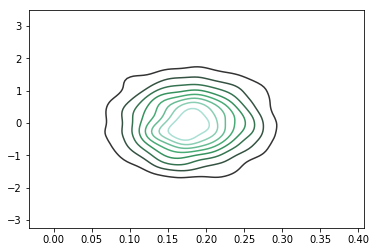

In [50]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [139]:
samples[:,10,2,0].mean()

0.09639029882481966

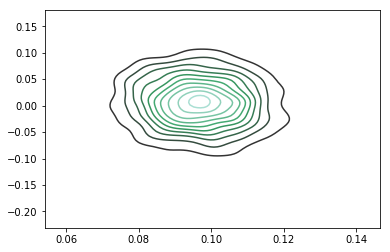

In [140]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [83]:
t = 10
# params[t]

In [84]:
np.mean(samples[:,t], axis=0)

array([[ 3.3247e-03, -7.3668e-03,  6.3002e-03,  1.1010e-02],
       [ 4.5848e-03, -3.7239e-04,  9.8147e-03,  3.6363e-03],
       [ 9.8738e-02, -1.8441e-03,  9.1986e-01,  1.1776e-04]])

In [85]:
np.std(samples[:,t], axis=0)

array([[0.0571, 0.032 , 0.0175, 0.0123],
       [0.0097, 0.0084, 0.0086, 0.0065],
       [0.0108, 0.0047, 0.024 , 0.003 ]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


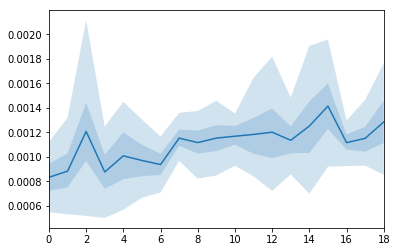

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


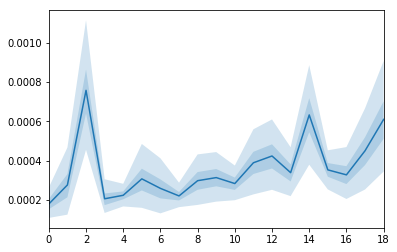

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


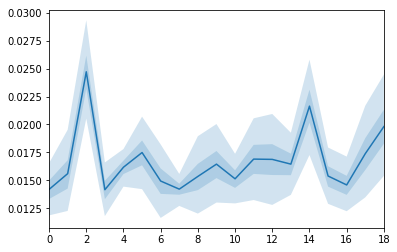

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()